In [ ]:
import os

def count_images_in_folder(folder_path):
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            count = len(os.listdir(class_folder))
            print(f"{class_name}: {count} images")

train_dir = "D:\\CIC\\6th Semester\\Pattern Recognition\\vs\\train"
test_dir = "D:\\CIC\\6th Semester\\Pattern Recognition\\vs\\test"

print("Train folder:")
count_images_in_folder(train_dir)

print("\nTest folder:")
count_images_in_folder(test_dir)


Train folder:
AD: 2561 images
CONTROL: 3010 images
PD: 906 images

Test folder:
AD: 639 images
CONTROL: 662 images
PD: 61 images


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = r"D:\CIC\6th Semester\Pattern Recognition\vs\train"
test_dir = r"D:\CIC\6th Semester\Pattern Recognition\vs\test"

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 6477 files belonging to 3 classes.
Found 1362 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print("Classes:", class_names)

# Count images in the training set
num_train = sum(1 for _ in train_ds.unbatch())
num_test = sum(1 for _ in test_ds.unbatch())
print(f"Training images: {num_train}")
print(f"Testing images: {num_test}")


Classes: ['AD', 'CONTROL', 'PD']
Training images: 6477
Testing images: 1362


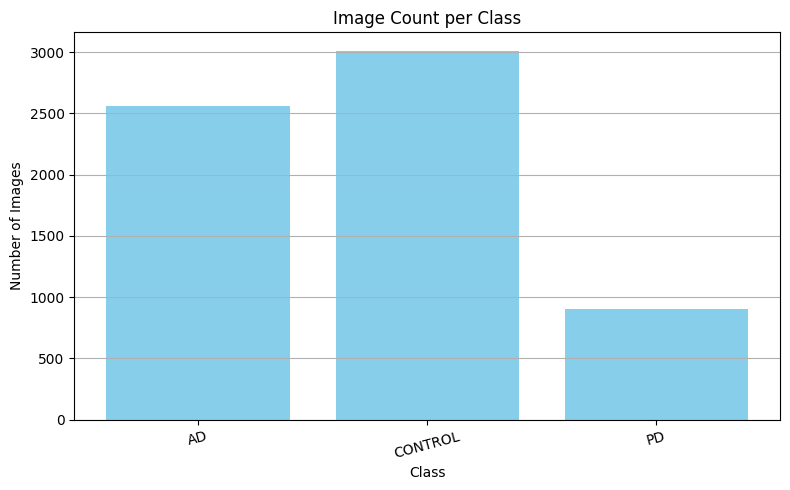

Average image size: 176.0 x 208.0


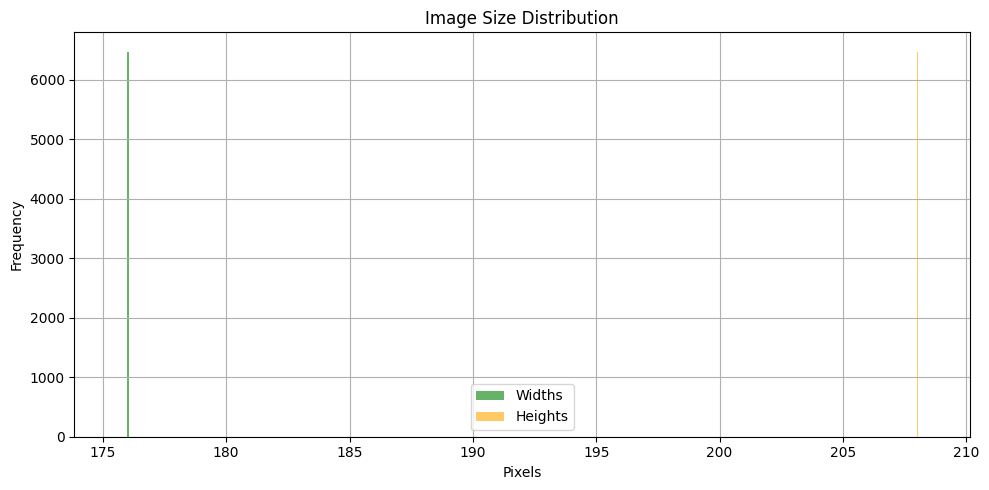

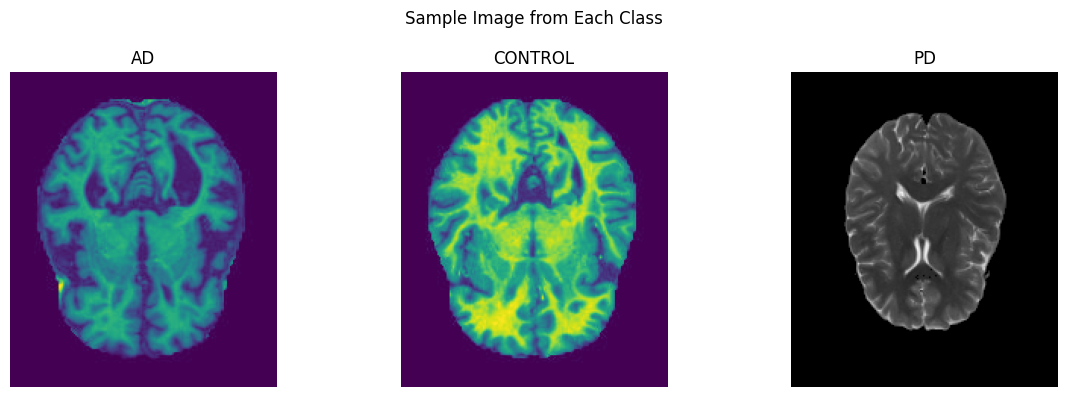

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# === Update these paths based on your actual folder ===
train_dir = "D:\\CIC\\6th Semester\\Pattern Recognition\\vs\\train"

# Containers
class_counts = {}
image_shapes = []
example_images = {}

# Loop through classes
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = 0
        for idx, file in enumerate(os.listdir(class_path)):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                count += 1
                img_path = os.path.join(class_path, file)
                try:
                    img = Image.open(img_path)
                    image_shapes.append(img.size)  # (width, height)
                    if idx == 0:
                        example_images[class_name] = img
                except Exception as e:
                    print(f"Failed to load image: {img_path} due to {e}")
        class_counts[class_name] = count

# --- Plot: Image count per class ---
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Plot: Width and Height Distribution ---
widths, heights = zip(*image_shapes)
print(f"Average image size: {np.mean(widths):.1f} x {np.mean(heights):.1f}")

plt.figure(figsize=(10, 5))
plt.hist(widths, bins=20, alpha=0.6, label='Widths', color='green')
plt.hist(heights, bins=20, alpha=0.6, label='Heights', color='orange')
plt.title("Image Size Distribution")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Show One Example per Class ---
plt.figure(figsize=(12, 4))
for i, (label, img) in enumerate(example_images.items()):
    plt.subplot(1, len(example_images), i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Image from Each Class")
plt.tight_layout()
plt.show()


In [ ]:
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Resize
    image = tf.image.adjust_contrast(image, 1.5)  # Enhance contrast
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Convert your preprocessed tf.data.Dataset into NumPy arrays
def dataset_to_numpy(ds):
    images, labels = [], []
    for batch_images, batch_labels in ds:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(images), np.concatenate(labels)

# Convert dataset to numpy
X_train_np, y_train_np = dataset_to_numpy(train_ds)

# Flatten images for traditional ML models
X_train_flat = X_train_np.reshape((X_train_np.shape[0], -1))

# Encode labels if they are not integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_np)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_flat, y_train_encoded)

print("After SMOTE:")
print("Resampled shape:", X_train_smote.shape)
print("Class distribution:", np.unique(y_train_smote, return_counts=True))


After SMOTE:
Resampled shape: (9030, 150528)
Class distribution: (array([0, 1, 2]), array([3010, 3010, 3010]))


In [ ]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.models import Model
import numpy as np
import tensorflow as tf

# Parameters
IMG_SIZE = (224, 224)
FEATURE_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

# SMOTE output: X_train_smote is flat; we will reshape each batch
def batch_generator_flat(X_flat, preprocess_func, batch_size=BATCH_SIZE):
    for i in range(0, len(X_flat), batch_size):
        batch_flat = X_flat[i:i+batch_size]
        batch_reshaped = batch_flat.reshape((-1, *FEATURE_SHAPE)).astype(np.float32)
        batch_preprocessed = preprocess_func(batch_reshaped)
        yield batch_preprocessed

# Load ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=FEATURE_SHAPE)
resnet_model = Model(inputs=resnet_base.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(resnet_base.output))

# Extract features using ResNet50
resnet_features = []
for batch in batch_generator_flat(X_train_smote, resnet_preprocess):
    features = resnet_model.predict(batch, verbose=0)
    resnet_features.append(features)
X_resnet_features = np.concatenate(resnet_features)
print("ResNet50 features shape:", X_resnet_features.shape)

# Load VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=FEATURE_SHAPE)
vgg_model = Model(inputs=vgg_base.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(vgg_base.output))

# Extract features using VGG16
vgg_features = []
for batch in batch_generator_flat(X_train_smote, vgg_preprocess):
    features = vgg_model.predict(batch, verbose=0)
    vgg_features.append(features)
X_vgg_features = np.concatenate(vgg_features)
print("VGG16 features shape:", X_vgg_features.shape)


ResNet50 features shape: (9030, 2048)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step
VGG16 features shape: (9030, 512)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)

# ResNet features
knn_model.fit(X_resnet_features, y_train_smote)
y_pred_resnet = knn_model.predict(X_resnet_features)
resnet_acc = accuracy_score(y_train_smote, y_pred_resnet)
print("KNN Accuracy with ResNet50 features:", resnet_acc)

# VGG features
knn_model.fit(X_vgg_features, y_train_smote)
y_pred_vgg = knn_model.predict(X_vgg_features)
vgg_acc = accuracy_score(y_train_smote, y_pred_vgg)
print("KNN Accuracy with VGG16 features:", vgg_acc)


KNN Accuracy with ResNet50 features: 0.9561461794019933
KNN Accuracy with VGG16 features: 0.9015503875968992


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# CNN Model
cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# Train CNN
history_cnn = cnn_model.fit(train_ds, validation_data=test_ds, epochs=30)

# Evaluate
cnn_loss, cnn_acc = cnn_model.evaluate(test_ds)
print(f"\nCNN Accuracy: {cnn_acc:.4f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 170s 823ms/step - accuracy: 0.5846 - loss: 0.9344 - val_accuracy: 0.6755 - val_loss: 0.6066
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 159s 783ms/step - accuracy: 0.7409 - loss: 0.5318 - val_accuracy: 0.6894 - val_loss: 0.6057
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 156s 767ms/step - accuracy: 0.7955 - loss: 0.4330 - val_accuracy: 0.6468 - val_loss: 0.6874
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 153s 753ms/step - accuracy: 0.8535 - loss: 0.3426 - val_accuracy: 0.6828 - val_loss: 0.6868
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 154s 758ms/step - accuracy: 0.9119 - loss: 0.2186 - val_accuracy: 0.6997 - val_loss: 0.7561
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 153s 752ms/step - accuracy: 0.9341 - loss: 0.1573 - val_accuracy: 0.6681 - val_loss: 1.0182
Epoch 7/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 156s 769ms/step - accuracy: 0.9531 - loss: 0.1097 - val_accuracy: 0.6894 - val_loss: 1.0212
Epoch 8/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 153s 753ms/step - accuracy: 0.9669 -